In [2]:
import os
import random
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow import keras
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.layers import Dense, Flatten, Input, RandomFlip, RandomRotation, RandomZoom, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import seaborn as sn
import cv2

In [3]:
class_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',      
    2: 'Speed limit (50km/h)',       
    3: 'Speed limit (60km/h)',      
    4: 'Speed limit (70km/h)',    
    5: 'Speed limit (80km/h)',      
    6: 'End of speed limit (80km/h)',     
    7: 'Speed limit (100km/h)',    
    8: 'Speed limit (120km/h)',     
    9: 'No passing',   
    10: 'No passing veh over 3.5 tons',     
    11: 'Right-of-way at intersection',     
    12: 'Priority road',    
    13: 'Yield',     
    14: 'Stop',       
    15: 'No vehicles',       
    16: 'Veh > 3.5 tons prohibited',       
    17: 'No entry',       
    18: 'General caution',     
    19: 'Dangerous curve left',      
    20: 'Dangerous curve right',   
    21: 'Double curve',      
    22: 'Bumpy road',     
    23: 'Slippery road',       
    24: 'Road narrows on the right',  
    25: 'Road work',    
    26: 'Traffic signals',      
    27: 'Pedestrians',     
    28: 'Children crossing',     
    29: 'Bicycles crossing',       
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',      
    32: 'End speed + passing limits',      
    33: 'Turn right ahead',     
    34: 'Turn left ahead',       
    35: 'Ahead only',      
    36: 'Go straight or right',      
    37: 'Go straight or left',      
    38: 'Keep right',     
    39: 'Keep left',      
    40: 'Roundabout mandatory',     
    41: 'End of no passing',      
    42: 'End no passing veh > 3.5 tons'
}

In [4]:
data_path = '/kaggle/input/gtsrb-german-traffic-sign'
train_data_path  = os.path.join(data_path, 'Train')
print(train_data_path)
test_data_path  = os.path.join(data_path, 'Test')
print(test_data_path)

/kaggle/input/gtsrb-german-traffic-sign/Train
/kaggle/input/gtsrb-german-traffic-sign/Test


In [5]:
train_image_paths = []
train_labels = []
for class_name in os.listdir(train_data_path):
    class_path = os.path.join(train_data_path, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for image_name in os.listdir(class_path):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):
            train_image_paths.append(os.path.join(class_path, image_name))
            train_labels.append(class_name)

In [6]:
train_df = pd.DataFrame({
    'path': train_image_paths,
    'label': train_labels
})


In [7]:
train_df

,path,label
0,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
1,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
2,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
3,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
4,/kaggle/input/gtsrb-german-traffic-sign/Train/...,7
...,...,...
39204,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24
39205,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24
39206,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24
39207,/kaggle/input/gtsrb-german-traffic-sign/Train/...,24


In [8]:
random_images_sample = random.sample(train_image_paths, 16)

  0%|          | 0/16 [00:00<?, ?it/s]

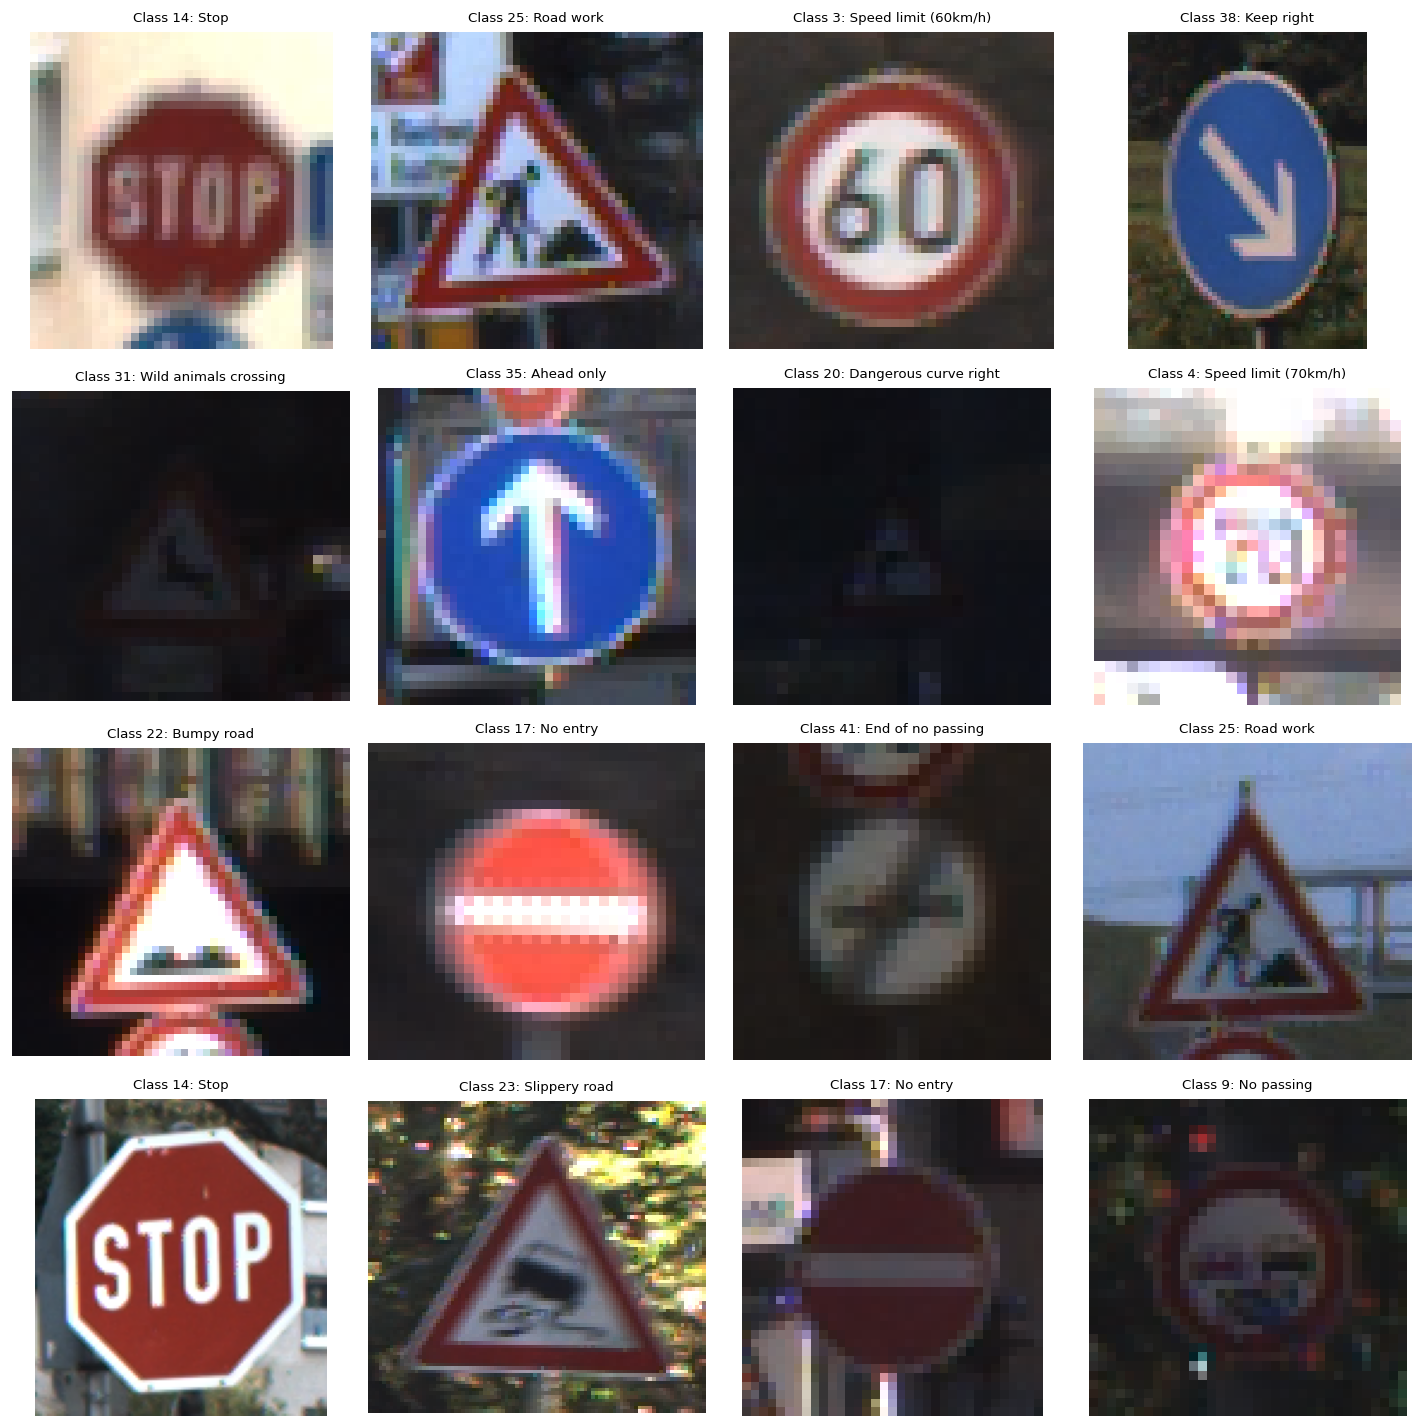

In [9]:
plt.figure(figsize=(12, 12), dpi=120)
for i, img_path in enumerate(tqdm(random_images_sample)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    class_id = int(os.path.dirname(img_path).split('/')[-1])
    plt.title(f'Class {class_id}: {class_names[class_id]}', fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
train_split_df, val_df = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42,
    stratify=train_df['label']  
)

In [11]:
test_csv = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
print(f"Test set: {len(test_csv)} samples")


Test set: 12630 samples


In [12]:
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [13]:
def copy_images_from_df(df, target_dir):
    for index, row in tqdm(df.iterrows(), total=len(df), desc=f"Copying to {os.path.basename(target_dir)}"):
        label = row['label']
        dest_dir = os.path.join(target_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        src = row['path']
        dst = os.path.join(dest_dir, os.path.basename(src))
        shutil.copy(src, dst)

In [14]:
copy_images_from_df(train_split_df, train_dir)
copy_images_from_df(val_df, val_dir)

Copying to train:   0%|          | 0/31367 [00:00<?, ?it/s]

Copying to val:   0%|          | 0/7842 [00:00<?, ?it/s]

In [15]:
IMG_SIZE = 224
batch_size = 32

In [16]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_vgg16,
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 31367 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.


In [18]:
from tensorflow.keras.applications import VGG16

vgg_trained_layer = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in vgg_trained_layer.layers:
    layer.trainable = False

VGG_model = keras.Sequential([
    vgg_trained_layer,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=len(train_generator.class_indices), activation='softmax')
])

VGG_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)


I0000 00:00:1748749226.809612      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
VGG_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,148,523 (80.68 MB)

 Trainable params: 6,433,835 (24.54 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='VGG_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [21]:
history = VGG_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748749231.696224     113 service.cc:148] XLA service 0x7966f800f060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748749231.696968     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748749232.090818     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/981 ━━━━━━━━━━━━━━━━━━━━ 1:15 77ms/step - accuracy: 0.0625 - loss: 17.8016 - precision: 0.0625 - recall: 0.0547              

I0000 00:00:1748749240.182026     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6378 - loss: 2.6506 - precision: 0.7478 - recall: 0.5763
Epoch 1: val_loss improved from inf to 0.40073, saving model to VGG_best_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 109s 100ms/step - accuracy: 0.6379 - loss: 2.6490 - precision: 0.7479 - recall: 0.5765 - val_accuracy: 0.8882 - val_loss: 0.4007 - val_precision: 0.9137 - val_recall: 0.8676
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9265 - loss: 0.2670 - precision: 0.9390 - recall: 0.9169
Epoch 2: val_loss improved from 0.40073 to 0.32527, saving model to VGG_best_model.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 93s 95ms/step - accuracy: 0.9265 - loss: 0.2670 - precision: 0.9390 - recall: 0.9169 - val_accuracy: 0.9172 - val_loss: 0.3253 - val_precision: 0.9279 - val_recall: 0.9106
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9578 - loss: 0.1527 - precision: 0.9640 - recall: 0.9538
Epoch 3: val_loss did not improve from 0.32527
981/981 ━━━━━━

In [22]:
output_path = '/kaggle/working/VGG_best_model.keras'
VGG_model.save(output_path)
print(f"Model saved to {output_path}")

Model saved to /kaggle/working/VGG_best_model.keras


In [23]:
import json
class_indices_path = '/kaggle/working/class_indices.json'
with open(class_indices_path, 'w') as f:
    json.dump(train_generator.class_indices, f)
print(f"Class indices saved to {class_indices_path}")

Class indices saved to /kaggle/working/class_indices.json


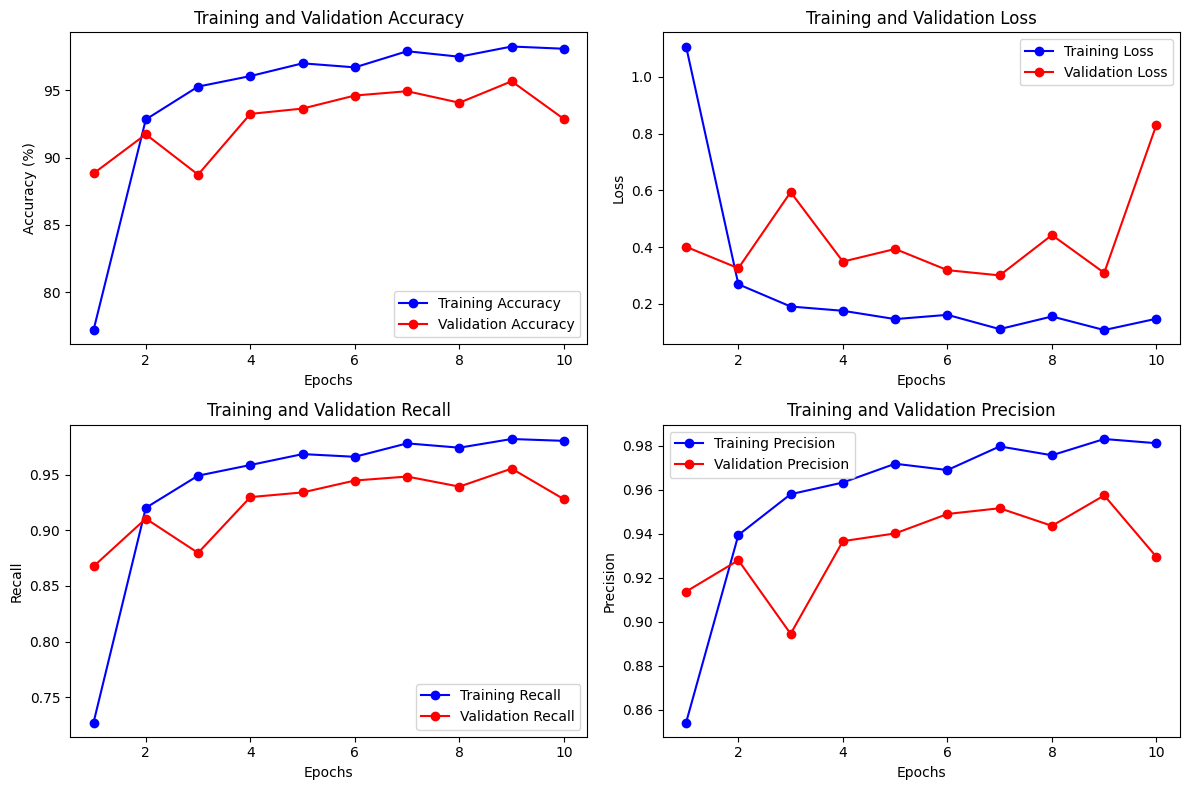

In [24]:
def plot_full_metrics(history):
    history_dict = history.history
    accuracy = [a * 100 for a in history_dict['accuracy']]
    val_accuracy = [va * 100 for va in history_dict['val_accuracy']]

    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    recall = history_dict['recall']
    val_recall = history_dict['val_recall']
    precision = history_dict['precision']
    val_precision = history_dict['val_precision']

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, recall, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(epochs, precision, 'bo-', label='Training Precision')
    plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_full_metrics(history)


In [25]:
test_csv = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
test_csv['ClassId'] = test_csv['ClassId'].astype(str)
test_csv['full_path'] = test_csv['Path'].apply(lambda x: os.path.join('/kaggle/input/gtsrb-german-traffic-sign', x))

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_csv,
    x_col='full_path',
    y_col='ClassId',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12630 validated image filenames belonging to 43 classes.


In [31]:
test_loss, test_accuracy, test_precision, test_recall = VGG_model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

395/395 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.7868 - loss: 2.6616 - precision: 0.7918 - recall: 0.7846
Test accuracy: 0.7851
Test precision: 0.7898
Test recall: 0.7834


395/395 ━━━━━━━━━━━━━━━━━━━━ 31s 76ms/step


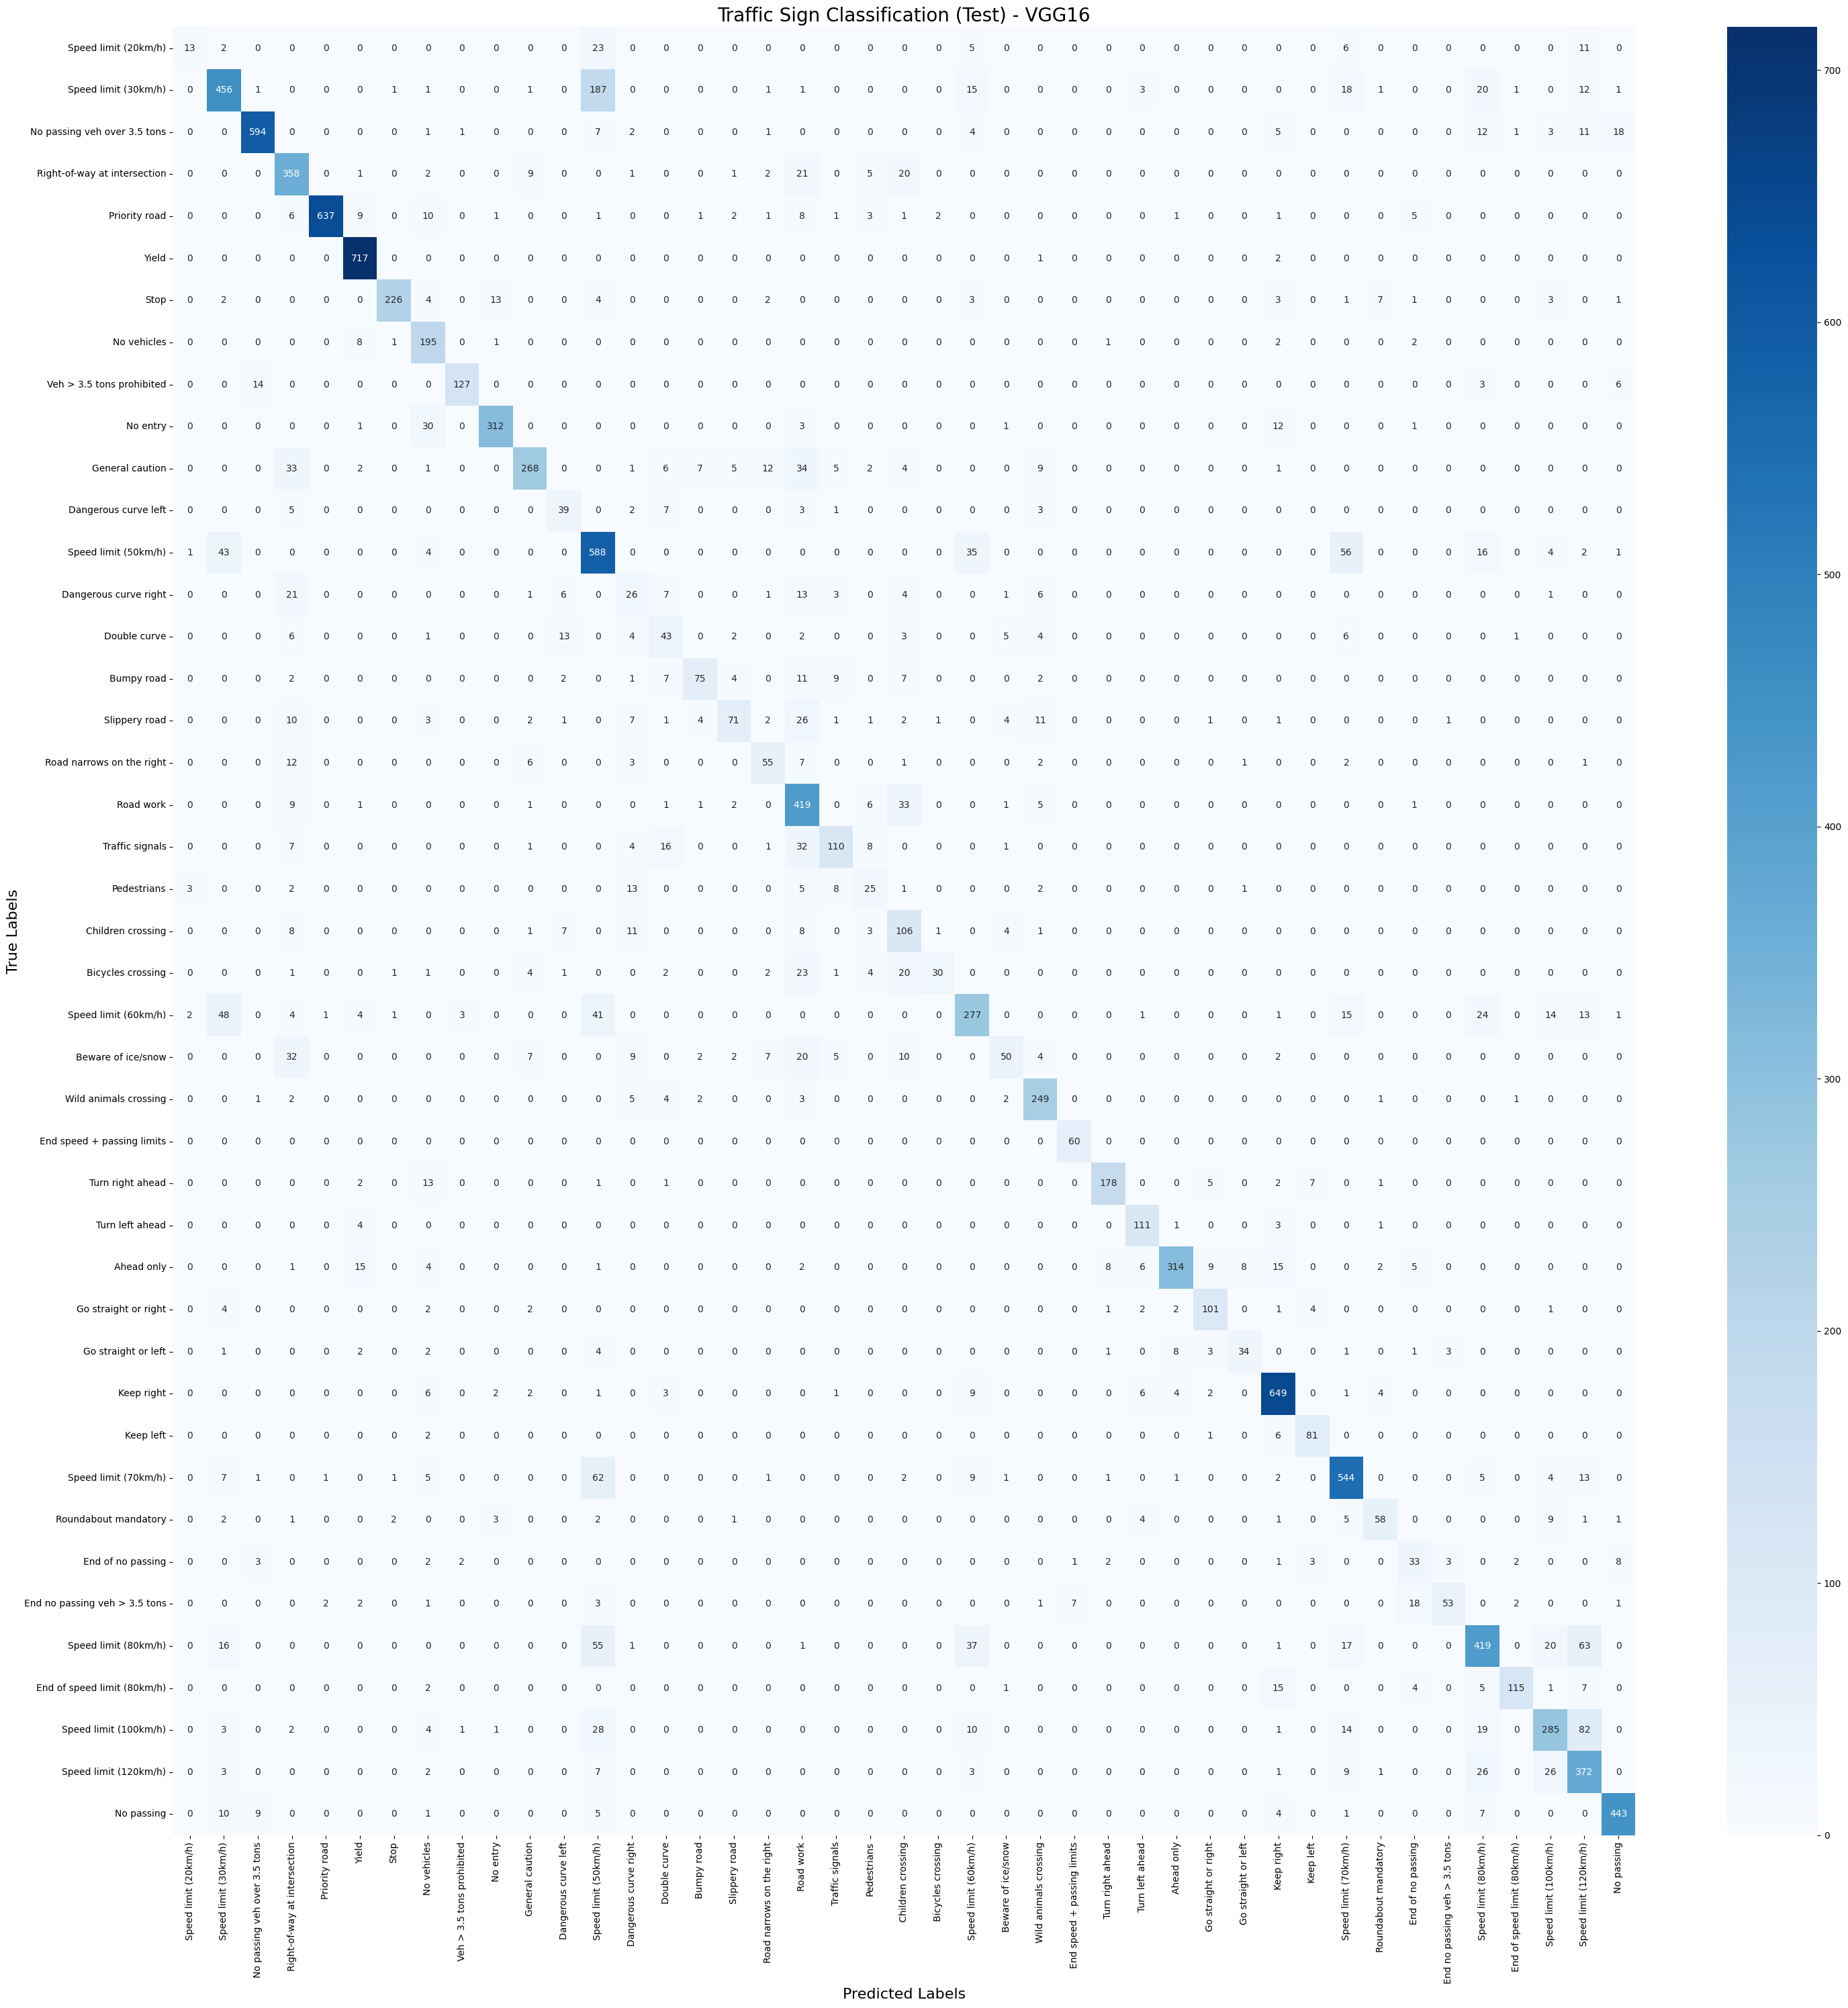

In [27]:
y_pred = VGG_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

cm = confusion_matrix(y_true, y_pred_classes)

class_indices = test_generator.class_indices
class_names_list = [class_names[int(idx)] for idx in class_indices.keys()]

plt.figure(figsize=(30, 30)) 
sn.heatmap(cm, annot=True, cmap='Blues', fmt='d',
           xticklabels=class_names_list,
           yticklabels=class_names_list)

plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Traffic Sign Classification (Test) - VGG16', fontsize=20)
plt.tight_layout()
plt.savefig('vgg16_cf_matrix.png', dpi = 300)
plt.show()

In [28]:
print("\nClassification Report:")
class_names_list = [class_names[int(idx)] for idx in test_generator.class_indices.keys()]
print(classification_report(y_true, y_pred_classes, target_names=class_names_list))


Classification Report:
                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.68      0.22      0.33        60
         Speed limit (30km/h)       0.76      0.63      0.69       720
 No passing veh over 3.5 tons       0.95      0.90      0.93       660
 Right-of-way at intersection       0.69      0.85      0.76       420
                Priority road       0.99      0.92      0.96       690
                        Yield       0.93      1.00      0.96       720
                         Stop       0.97      0.84      0.90       270
                  No vehicles       0.65      0.93      0.77       210
    Veh > 3.5 tons prohibited       0.95      0.85      0.89       150
                     No entry       0.94      0.87      0.90       360
              General caution       0.88      0.69      0.77       390
         Dangerous curve left       0.57      0.65      0.60        60
         Speed limit (50km/h)       0.58      0.78  

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


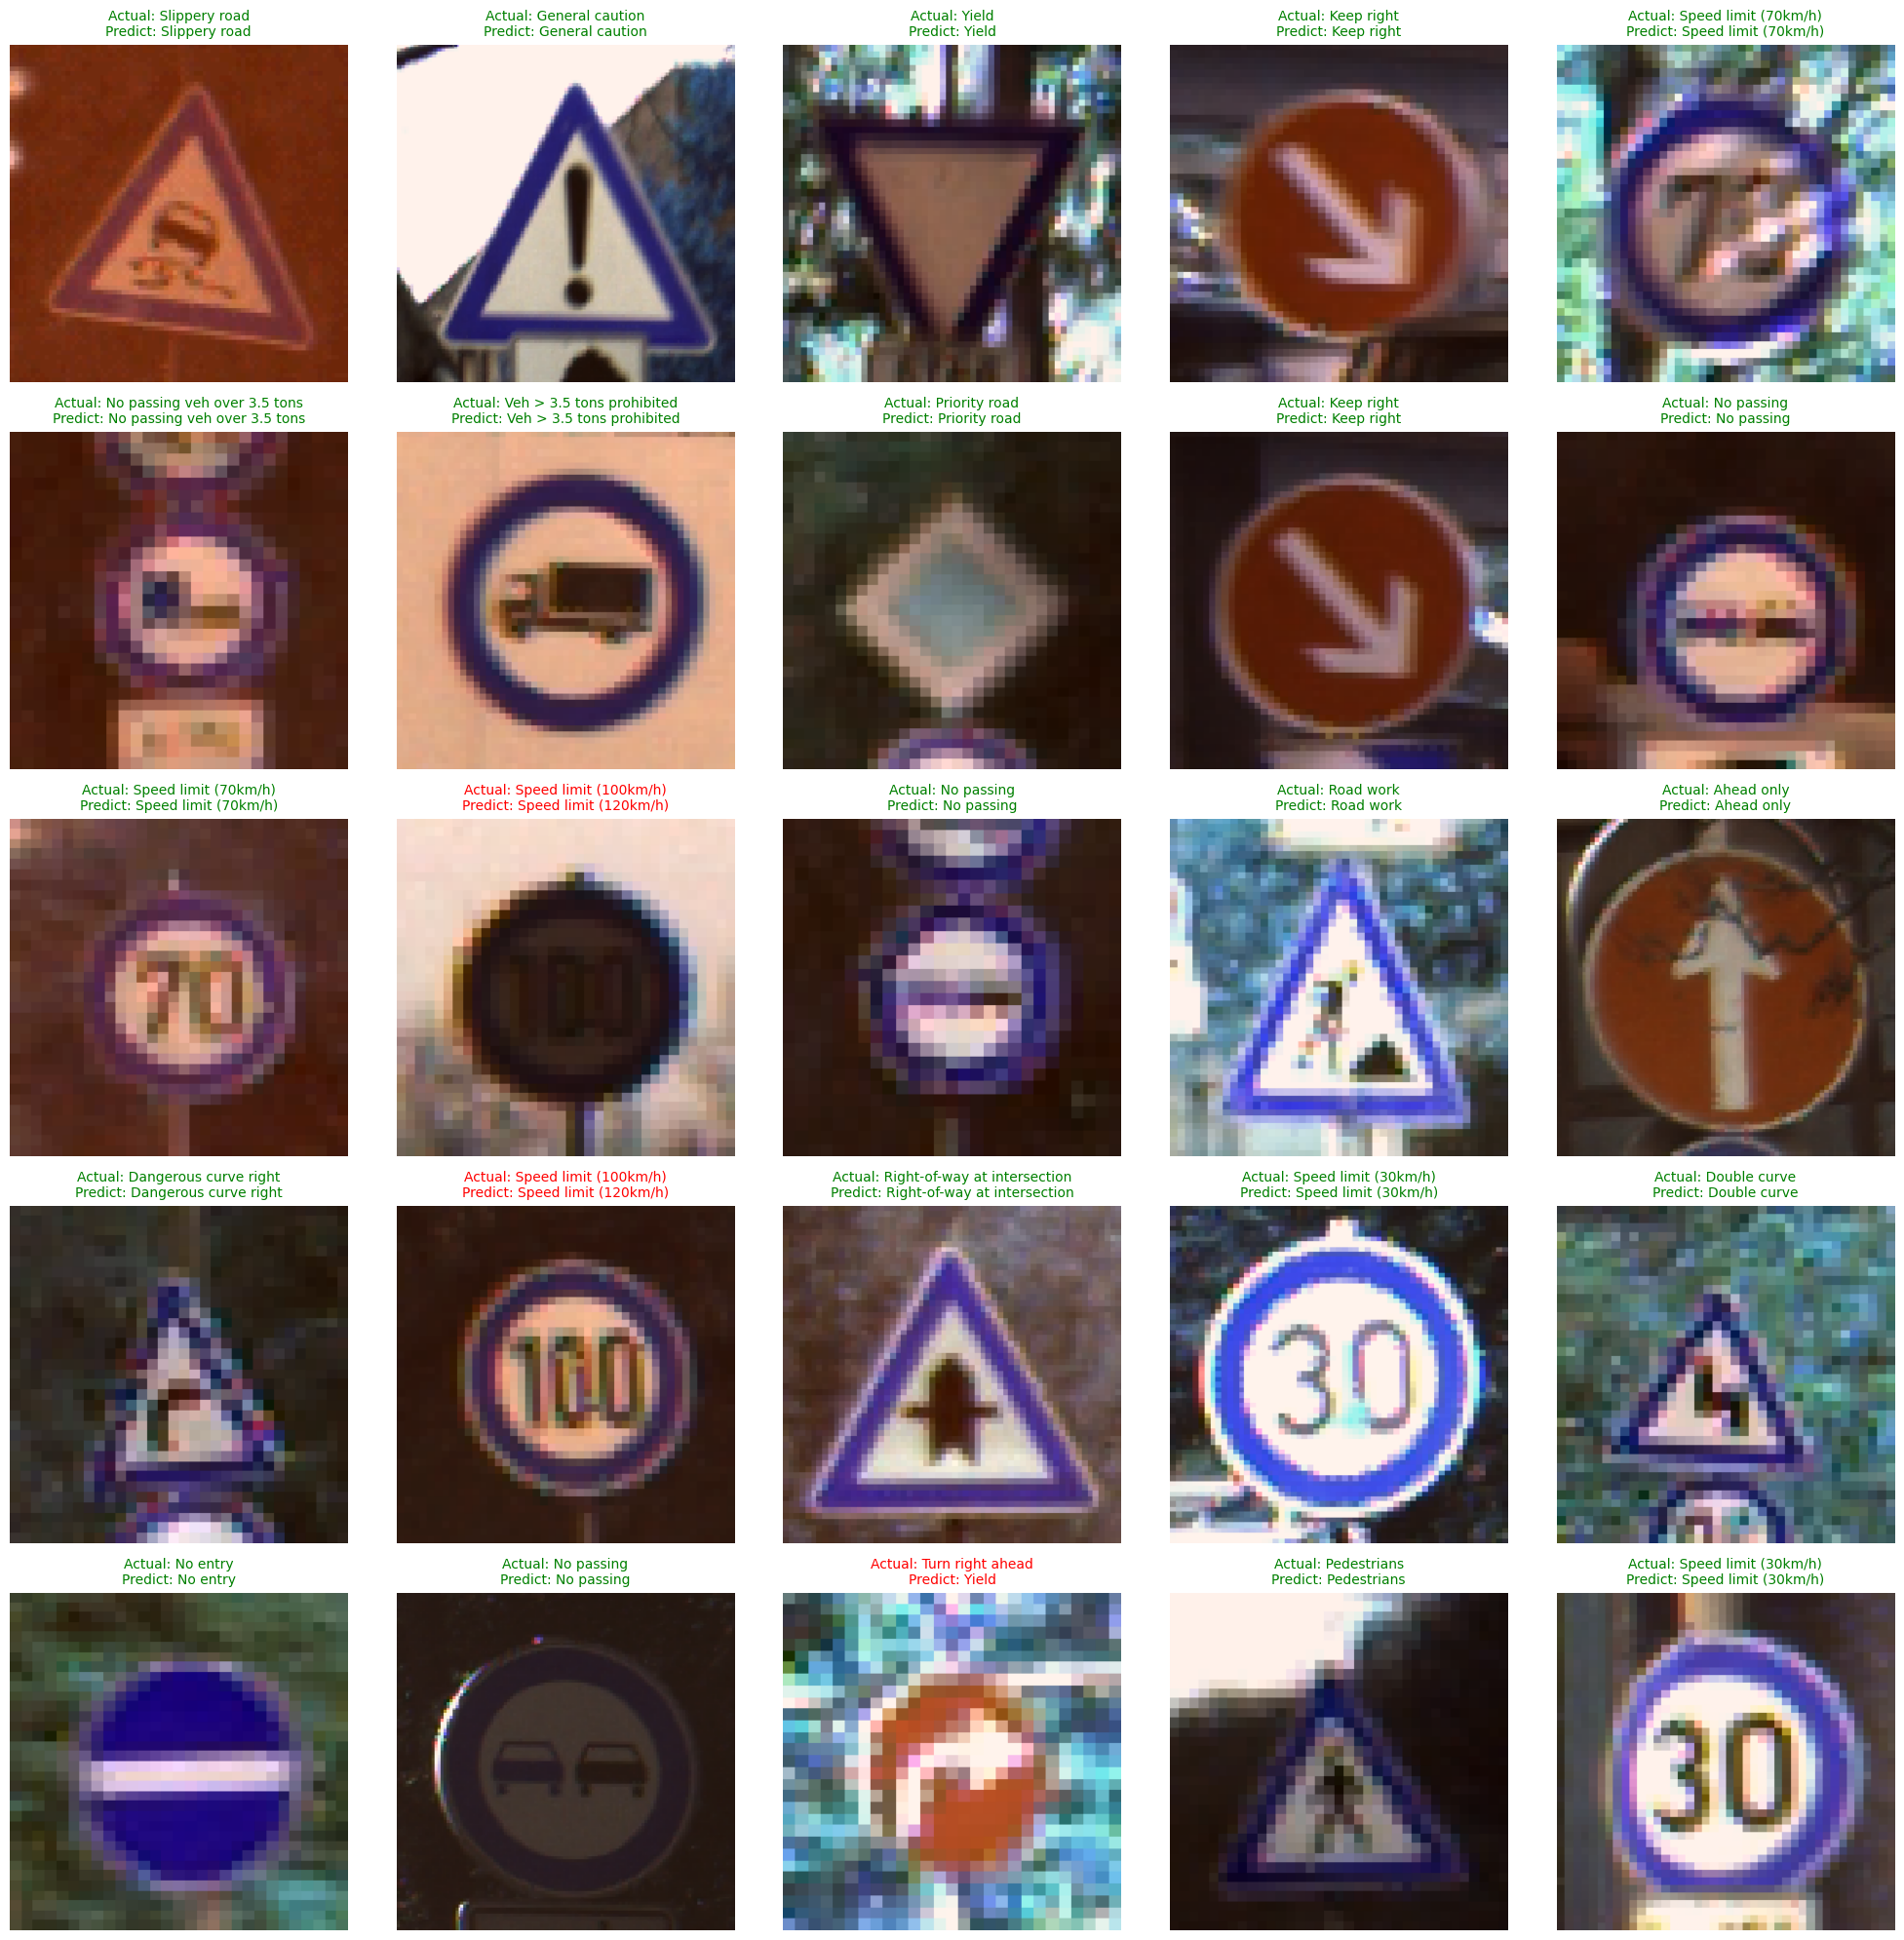

In [29]:
def visualize_random_test_images(generator, model, num_images=25):
    generator.reset()
    all_images = []
    all_labels = []
    samples_needed = num_images
    while samples_needed > 0:
        try:
            batch_x, batch_y = next(generator)
            all_images.append(batch_x)
            all_labels.append(batch_y)
            samples_needed -= batch_x.shape[0]
        except StopIteration:
            generator.reset()
            continue
        
        if samples_needed <= 0:
            break
    all_images = np.vstack(all_images)
    all_labels = np.vstack(all_labels)
    indices = np.random.choice(all_images.shape[0], num_images, replace=False)
    selected_images = all_images[indices]
    selected_labels = all_labels[indices]
    predictions = model.predict(selected_images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(selected_labels, axis=1)
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        img = selected_images[i].copy()
        img = (img - img.min()) / (img.max() - img.min()) * 255.0
        plt.imshow(img.astype(np.uint8))
        plt.axis('off')
        
        class_indices_inv = {v: k for k, v in generator.class_indices.items()}
        true_class = int(class_indices_inv[true_classes[i]])
        pred_class = int(class_indices_inv[pred_classes[i]])
        
        true_name = class_names[true_class]
        pred_name = class_names[pred_class]
        
        color = 'green' if true_class == pred_class else 'red'
        
        plt.title(f"Actual: {true_name}\nPredict: {pred_name}", 
                 color=color, fontsize=10)
    
    plt.tight_layout()
    plt.show()

visualize_random_test_images(test_generator, VGG_model)